In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")



/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# It pays to bet on marginal value (ie on sell days) as this portfolio does better than the buy days that bets on marginal growth

# When we add volume to the signal, the signal reverses and it becomes better to bet on GROWTH! (ONLY AT 1 DAY HORIZON!)

In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data.columns.values

array(['tradedate', 'osid', 'symbol', 'coname', 'sector_group', 'max_dt',
       'previoustradedate', 'tickssinceipo', 'alpha', 'stdev_alpha',
       'pricehigh', 'pricelow', 'priceclose', 'priceopen', 'splitfactor',
       'cumsplitfactor', 'volume', 'unadjustedpriceclose', 'pricepctchgd',
       'avgvol50d', 'avgdollarvol50d', 'growthscore', 'growthrank',
       'lastupdatetime', 'epsq1', 'epsq2', 'epsq3', 'epsq4', 'epsq5',
       'epsq6', 'epsq7', 'epsq8', 'epshighq1', 'epshighq2', 'epshighq3',
       'epshighq4', 'epshighq5', 'epshighq6', 'epshighq7', 'epshighq8',
       'epslowq1', 'epslowq2', 'epslowq3', 'epslowq4', 'epslowq5',
       'epslowq6', 'epslowq7', 'epslowq8', 'salesq1', 'salesq2',
       'salesq3', 'salesq4', 'salesq5', 'salesq6', 'salesq7', 'salesq8',
       'saleshighq1', 'saleshighq2', 'saleshighq3', 'saleshighq4',
       'saleshighq5', 'saleshighq6', 'saleshighq7', 'saleshighq8',
       'saleslowq1', 'saleslowq2', 'saleslowq3', 'saleslowq4',
       'saleslowq5', 's

In [3]:
data = data[data['growthrank'].notna()].reset_index(drop=True).copy() #drop na values

np.unique(data['growthrank']) #1-99 score

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90., 91.,
       92., 93., 94., 95., 96., 97., 98., 99.])

# growthrank

### Now, let's trade on when growthrank changes
### the times when 'growthrank' changes
###### Buy when change, so when df['growthrank'].diff(1) > 0
###### Sell when no change, so when df['growthrank'].diff(1) < 0
### with 1 day, 1 week, 2 weeks, 3 weeks, and 4 weeks holding period 
### (AHEAD, not backward... so our ret, ret5d, 10d, 15d, and 20d needs to be forward)
### Thus, we will use ret5d_'lag' !!

# Set buy_tomorrow>0 when df['growthrank'].diff(1) > 0
# Set Sell_tomorrow>0 when df['growthrank'].diff(1) < 0


In [4]:
data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data[data['growthrank'].notna()].reset_index(drop=True).copy() #drop na values

data['buy_tomorrow'] = np.where(data['growthrank'].diff(1) > 0, 1, 0)
data['sell_tomorrow'] = np.where(data['growthrank'].diff(1) < 0, 1, 0)


print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'


Total number of Buys:  601485
Total number of Sells:  631940
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]


In [5]:
data = cp.trade_on_valid_lags_only(data)


There are  132  problems for buying

There are  146  problems for selling
Total number of Buys:  601353
Total number of Sells:  631794


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [6]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)


There are  519  problems for buying

There are  530  problems for selling
Total number of Buys:  2618173
Total number of Sells:  2624377

There are  504  problems for buying

There are  515  problems for selling
Total number of Buys:  2549409
Total number of Sells:  2560631

There are  464  problems for buying

There are  494  problems for selling
Total number of Buys:  2393687
Total number of Sells:  2416316

There are  352  problems for buying

There are  389  problems for selling
Total number of Buys:  1915262
Total number of Sells:  1966745

There are  24  problems for buying

There are  25  problems for selling
Total number of Buys:  600651
Total number of Sells:  631066


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.109
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           9.42e-09
Time:                        19:12:33   Log-Likelihood:                 18218.
No. Observations:                6715   AIC:                        -3.642e+04
Df Residuals:                    6708   BIC: 

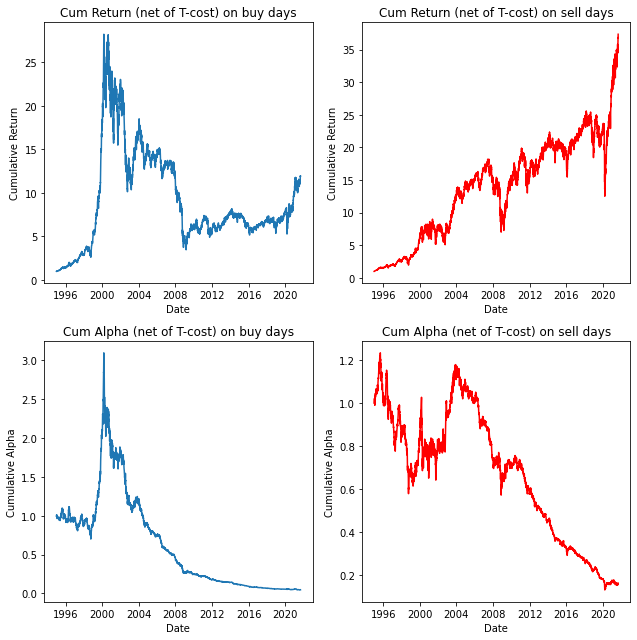

In [7]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.808
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.37e-09
Time:                        19:14:20   Log-Likelihood:                 18318.
No. Observations:                6715   AIC:                        -3.662e+04
Df Residuals:                    6708   BIC: 

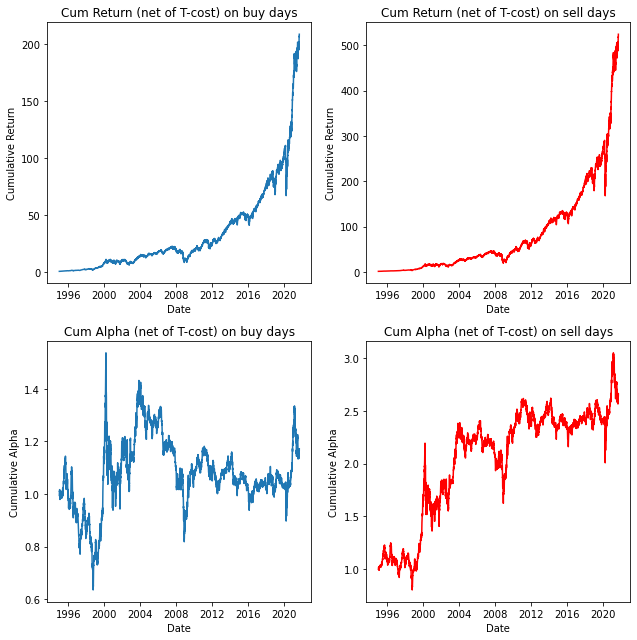

In [8]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.748
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.62e-09
Time:                        19:17:11   Log-Likelihood:                 18295.
No. Observations:                6715   AIC:                        -3.658e+04
Df Residuals:                    6708   BIC: 

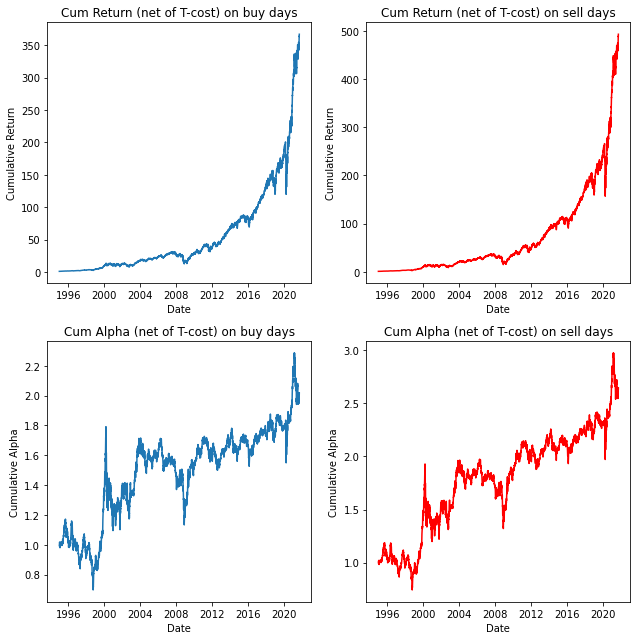

In [9]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.616
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           2.34e-09
Time:                        19:20:52   Log-Likelihood:                 18281.
No. Observations:                6715   AIC:                        -3.655e+04
Df Residuals:                    6708   BIC: 

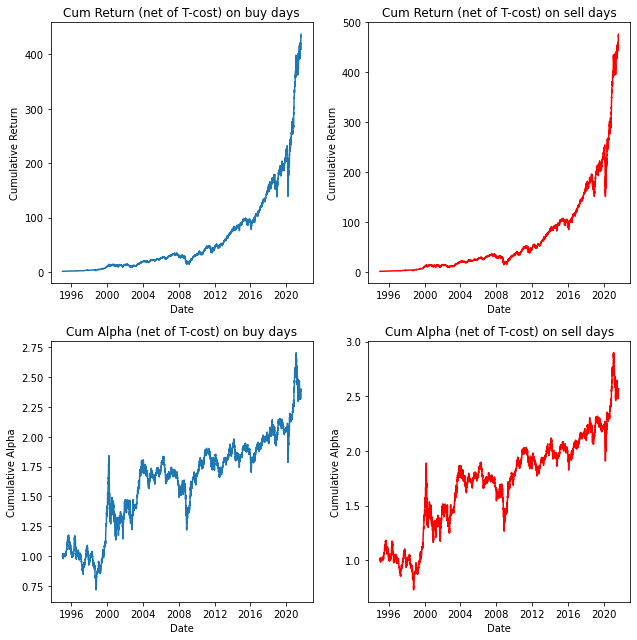

In [10]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.677
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.97e-09
Time:                        19:26:38   Log-Likelihood:                 18273.
No. Observations:                6715   AIC:                        -3.653e+04
Df Residuals:                    6708   BIC: 

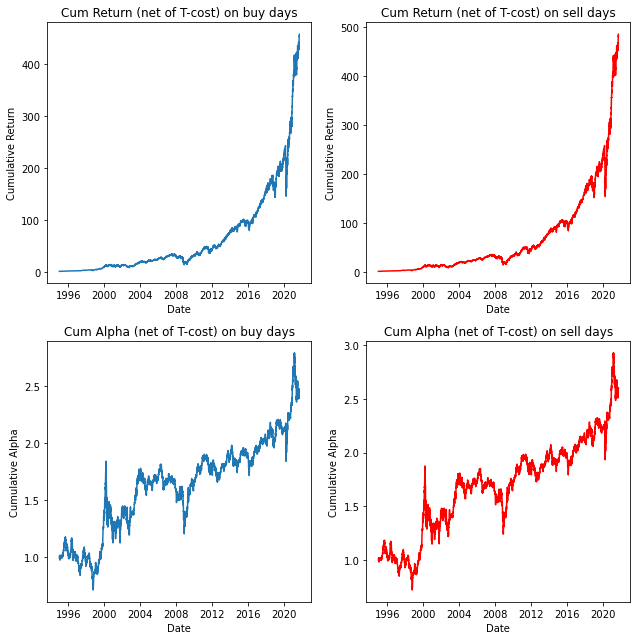

In [11]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)

# BREAK!
# BREAK!
# BREAK!

# Now, let's do the same thing but COMBINING THE EVENT WITH VOLUME SPIKES!

# Set buy_tomorrow>0 when df['growthrank'].diff(1) > 0 AND vol spikes above the 50_day_avgVol
# Set Sell_tomorrow>0 when df['growthrank'].diff(1) < 0 AND vol falls below the 50_day_avgVol



In [12]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl') #reload the data in order to start from scratch!!!

data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data[data['growthrank'].notna()].reset_index(drop=True).copy() #drop na values
data = data.loc[data['volume'].notna(),:].reset_index(drop=True).copy()
data = data.loc[data['avgvol50d'].notna(),:].reset_index(drop=True).copy()

data['buy_tomorrow'] = np.where((data['growthrank'].diff(1) > 0) & (data['volume']>data['avgvol50d']), 1, 0)
data['sell_tomorrow'] = np.where((data['growthrank'].diff(1) < 0) & (data['volume']<data['avgvol50d']), 1, 0)


print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there are only 0 or 1 values in 'buy_tomorrow'
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there are only 0 or 1 values in 'sell_tomorrow'



data = cp.trade_on_valid_lags_only(data)

data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)

Total number of Buys:  276301
Total number of Sells:  386650
Unique buy_tomorrow values:  [0 1]
Unique sell_tomorrow values:  [0 1]

There are  68  problems for buying

There are  90  problems for selling
Total number of Buys:  276233
Total number of Sells:  386560

There are  399  problems for buying

There are  486  problems for selling
Total number of Buys:  2152422
Total number of Sells:  2395257

There are  366  problems for buying

There are  459  problems for selling
Total number of Buys:  1922718
Total number of Sells:  2238461

There are  302  problems for buying

There are  413  problems for selling
Total number of Buys:  1576484
Total number of Sells:  1959897

There are  184  problems for buying

There are  279  problems for selling
Total number of Buys:  1023044
Total number of Sells:  1396114

There are  16  problems for buying

There are  11  problems for selling
Total number of Buys:  275927
Total number of Sells:  386037



There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5.765
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           5.36e-06
Time:                        19:33:58   Log-Likelihood:                 17795.
No. Observations:                6705   AIC:                        -3.558e+04
Df Residuals:                    6698   BIC: 

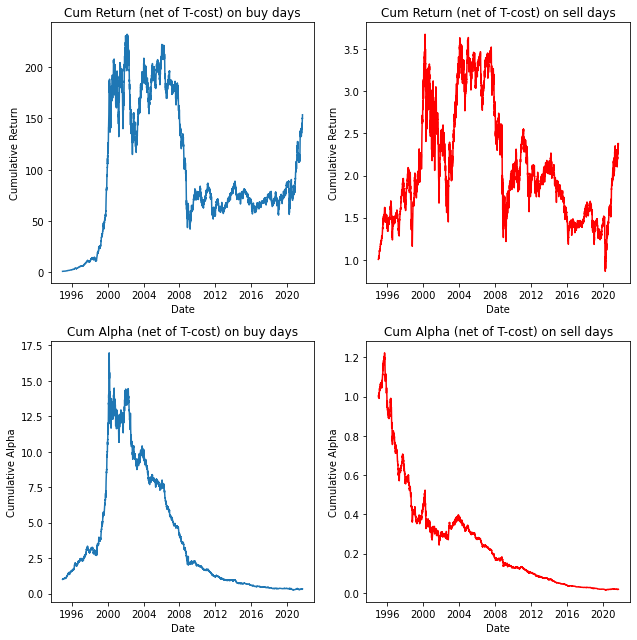

In [13]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.001
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           1.27e-08
Time:                        19:35:20   Log-Likelihood:                 18258.
No. Observations:                6715   AIC:                        -3.650e+04
Df Residuals:                    6708   BIC: 

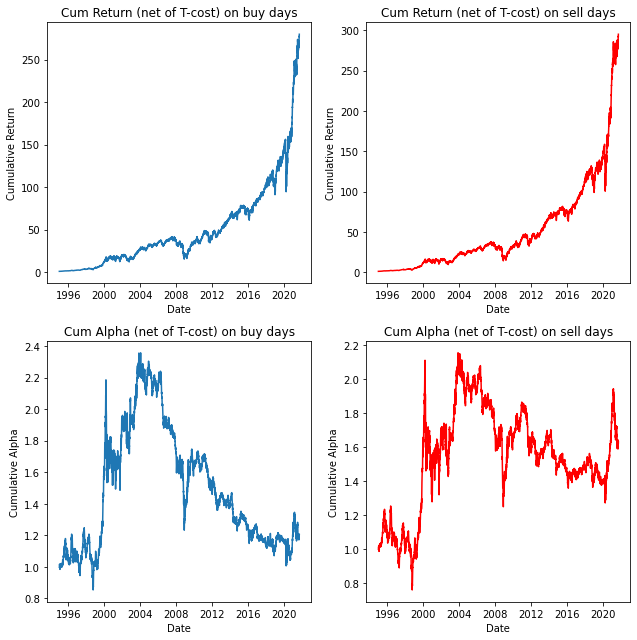

In [14]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8.315
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           5.35e-09
Time:                        19:37:08   Log-Likelihood:                 18263.
No. Observations:                6715   AIC:                        -3.651e+04
Df Residuals:                    6708   BIC: 

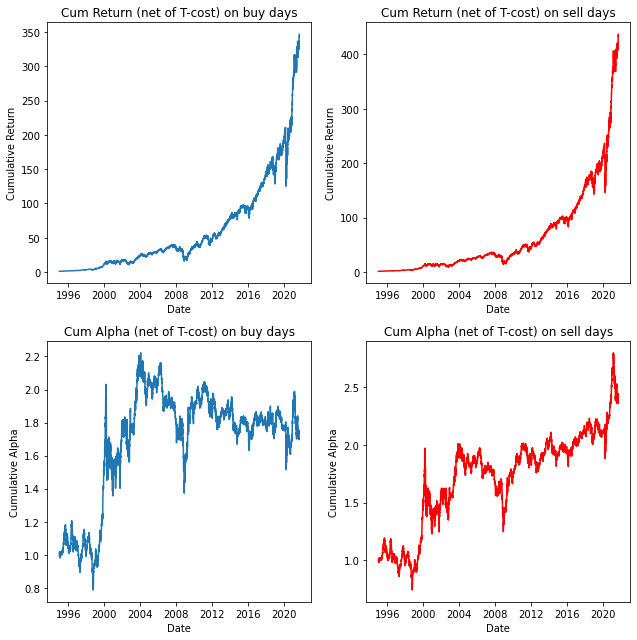

In [15]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.393
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           4.32e-09
Time:                        19:39:27   Log-Likelihood:                 18262.
No. Observations:                6715   AIC:                        -3.651e+04
Df Residuals:                    6708   BIC: 

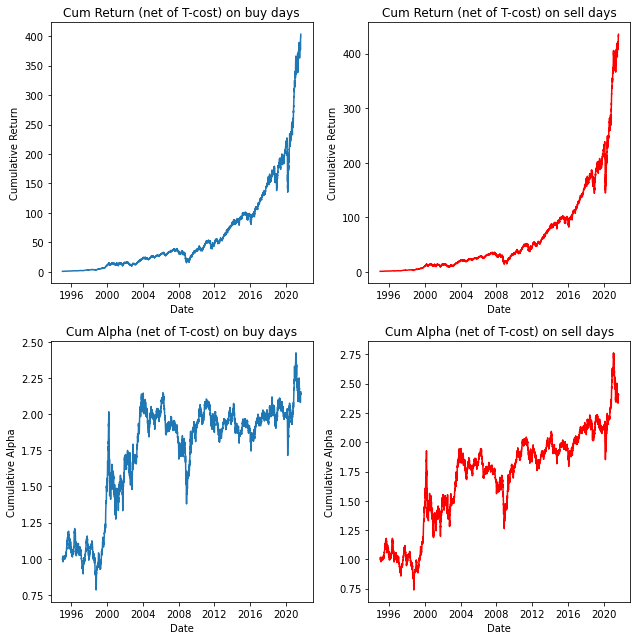

In [16]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  1  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     8.387
Date:                Sat, 04 Dec 2021   Prob (F-statistic):           4.39e-09
Time:                        19:42:21   Log-Likelihood:                 18263.
No. Observations:                6715   AIC:                        -3.651e+04
Df Residuals:                    6708   BIC: 

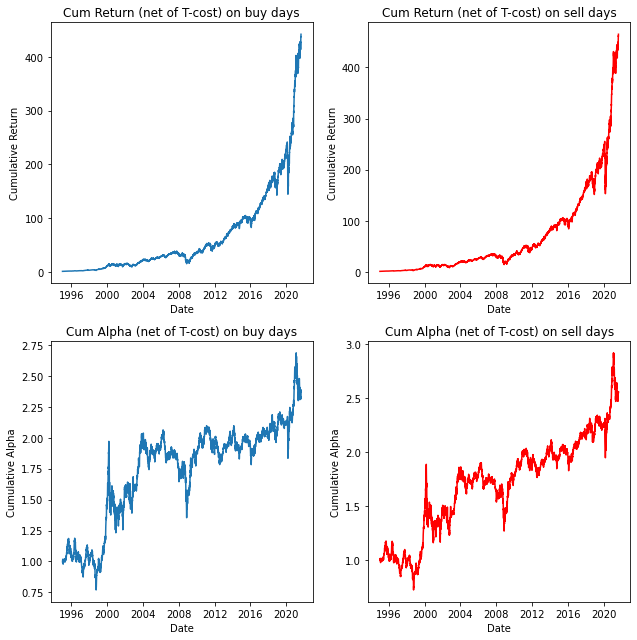

In [17]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)